In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.ad import *
from darts.models import GlobalNaiveAggregate, GlobalNaiveDrift, GlobalNaiveSeasonal

import os

In [6]:
def forecast_and_plot(model, series_train, series_val, n_jobs=True, plot=False):
    if n_jobs:
        pred = model.predict(n=len(series_val), series=series_train, n_jobs=-1)
    else:
        pred = model.predict(n=len(series_val), series=series_train)

    mape_loss = mape(series_val, pred)
    mae_loss = mae(series_val, pred)

    # print(f"model {model} obtains MAPE: {mape_loss}")
    # print(f"model {model} obtains MAE: {mae_loss}")

    if plot:
        fig, ax = plt.subplots(figsize=(30, 5))
        series_train.plot(label="train")
        series_val.plot(label="true")
        pred.plot(label="prediction")

    return mape_loss, mae_loss


def process_file(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    df = df.resample("W").ffill()
    file_name = os.path.basename(file_path)
    base_name = os.path.splitext(file_name)[0]
    df.to_csv(f"data/processed/walmart_sales/bySD_fillDates/{base_name}.csv")


def process_files_in_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            process_file(file_path)


def load_all_timeseries(dir_path):
    all_files = []
    all_series = []
    train_series = []
    val_series = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            file_path = os.path.join(root, file)
            ts = TimeSeries.from_csv(
                file_path,
                time_col="Date",
                value_cols="Weekly_Sales",
                freq="W-FRI",
            )
            train_ts, val_ts = ts.split_before(0.80)

            all_files.append(file)
            all_series.append(ts)
            train_series.append(train_ts)
            val_series.append(val_ts)

    return all_files, all_series, train_series, val_series


def eval_on_all_series(model, train_series, val_series, n_jobs=True):
    mape_losses, mae_losses = [], []
    for i in range(len(val_series)):
        mape_loss, mae_loss = forecast_and_plot(
            model=model,
            series_train=train_series[i],
            series_val=val_series[i],
            n_jobs=n_jobs,
            plot=False,
        )
        mape_losses.append(mape_loss)
        mae_losses.append(mae_loss)

    print(f"mean MAPE: {np.mean(mape_losses)}")
    print(f"mean MAE: {np.mean(mae_losses)}")

    return mape_losses, mae_losses


def print_losses(model_name, mape_losses, mae_losses):
    print(f"{model_name}:")
    print(f"mean MAPE: {np.mean(mape_losses)}")
    print(f"mean MAE: {np.mean(mae_losses)}")

In [7]:
all_files, all_series, train_series, val_series = load_all_timeseries(
    "data/processed/walmart_sales/BySD"
)

In [ ]:
linear_regression_model = LinearRegressionModel(
    lags=64,
    output_chunk_length=1,
)
linear_regression_model.fit(train_series)
# linear_regression_model.save("linear_regression.pkl")
# linear_regression_mape_losses, linear_regression_mae_losses = eval_on_all_series(
#     linear_regression_model, train_series, val_series, n_jobs=False
# )

In [ ]:
print_losses(
    "linear_regression_model",
    linear_regression_mape_losses,
    linear_regression_mae_losses,
)

In [ ]:
nhits_model = NHiTSModel(
    input_chunk_length=64,
    output_chunk_length=1,
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1, "strategy": "ddp"},
)
nhits_model.fit(train_series, epochs=2, verbose=True)
nhits_model.save("nhits.pkl")
nhits_mape_losses, nhits_mae_losses = eval_on_all_series(
    nhits_model, train_series, val_series
)

In [ ]:
print_losses("nhits_model", nhits_mape_losses, nhits_mae_losses)

In [ ]:
dlinear_model = DLinearModel(input_chunk_length=64, output_chunk_length=1)
dlinear_model.fit(train_series, epochs=200, verbose=False)
dlinear_model.save("dlinear.pkl")
dlinear_mape_losses, dlinear_mae_losses = eval_on_all_series(
    dlinear_model, train_series, val_series
)

In [ ]:
print_losses("dlinear_model", dlinear_mape_losses, dlinear_mae_losses)

In [ ]:
nbeats_model = NBEATSModel(input_chunk_length=64, output_chunk_length=1)
nbeats_model.fit(train_series, epochs=200, verbose=False)
nbeats_model.save("nbeats.pkl")
nbeats_mape_losses, nbeats_mae_losses = eval_on_all_series(
    nbeats_model, train_series, val_series
)

In [ ]:
print_losses("nbeats_model", nbeats_mape_losses, nbeats_mae_losses)

In [ ]:
nlinear_model = NLinearModel(input_chunk_length=64, output_chunk_length=1)
nlinear_model.fit(train_series, epochs=200, verbose=True)
nlinear_model.save("nlinear.pkl")
nlinear_mape_losses, nlinear_mae_losses = eval_on_all_series(
    nlinear_model, train_series, val_series
)

In [ ]:
print_losses("nlinear_model", nlinear_mape_losses, nlinear_mae_losses)

In [ ]:
rnn_model = RNNModel(input_chunk_length=24, output_chunk_length=1)
rnn_model.fit(train_series, epochs=100, verbose=True)
rnn_model.save("rnn.pkl")
rnn_mape_losses, rnn_mae_losses = eval_on_all_series(
    rnn_model, train_series, val_series
)

In [5]:
print_losses("rnn_model", rnn_mape_losses, rnn_mae_losses)

rnn_model:
mean MSE: 443730315.2365976
mean MAE: 9471.355253953812


In [ ]:
naive_agg_model = GlobalNaiveAggregate(input_chunk_length=64, output_chunk_length=1)
naive_agg_model.fit(train_series, epochs=200, verbose=True)
# naive_agg_model.save("naive_agg.pkl")
naive_agg_mape_losses, naive_agg_mae_losses = eval_on_all_series(
    naive_agg_model, train_series, val_series
)

In [ ]:
print_losses("naive_agg_model", naive_agg_mape_losses, naive_agg_mae_losses)

In [ ]:
naive_drift_model = GlobalNaiveDrift(input_chunk_length=64, output_chunk_length=1)
naive_drift_model.fit(train_series, epochs=200, verbose=True)
# naive_drift_model.save("naive_drift.pkl")
naive_drift_mape_losses, naive_drift_mae_losses = eval_on_all_series(
    naive_drift_model, train_series, val_series
)

In [ ]:
print_losses("naive_drift_model", naive_drift_mape_losses, naive_drift_mae_losses)

In [ ]:
naive_season_model = GlobalNaiveSeasonal(input_chunk_length=64, output_chunk_length=1)
naive_season_model.fit(train_series, epochs=200, verbose=True)
# naive_season_model.save("naive_season.pkl")
naive_season_mape_losses, naive_season_mae_losses = eval_on_all_series(
    naive_season_model, train_series, val_series
)

In [ ]:
print_losses("naive_season_model", naive_season_mape_losses, naive_season_mae_losses)

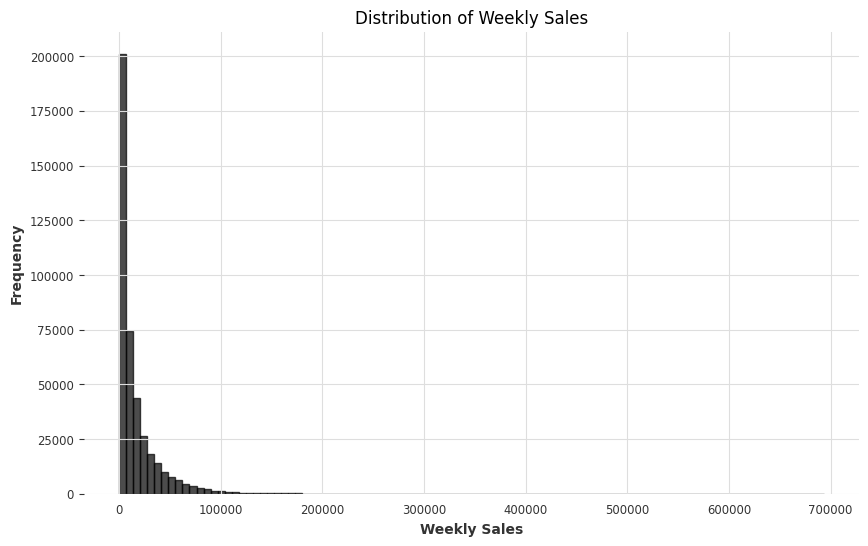

Minimum Weekly Sales: 0.01
Maximum Weekly Sales: 693099.36
Mean Weekly Sales: 15982.617027333008
Median Weekly Sales: 7612.92
25th Percentile of Weekly Sales: 2080.52
75th Percentile of Weekly Sales: 20206.365
Standard Deviation of Weekly Sales: 22711.003589133878


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/processed/walmart_sales/train_processed.csv")

plt.figure(figsize=(10, 6))
plt.hist(df["Weekly_Sales"], bins=100, edgecolor="k", alpha=0.7)
plt.title("Distribution of Weekly Sales")
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

min_sales = df["Weekly_Sales"].min()
max_sales = df["Weekly_Sales"].max()
std_sales = df["Weekly_Sales"].std()
mean_sales = df["Weekly_Sales"].mean()
percentile_25 = df["Weekly_Sales"].quantile(0.25)
percentile_75 = df["Weekly_Sales"].quantile(0.75)
median_sales = df["Weekly_Sales"].median()

print(f"Minimum Weekly Sales: {min_sales}")
print(f"Maximum Weekly Sales: {max_sales}")
print(f"Mean Weekly Sales: {mean_sales}")
print(f"Median Weekly Sales: {median_sales}")
print(f"25th Percentile of Weekly Sales: {percentile_25}")
print(f"75th Percentile of Weekly Sales: {percentile_75}")
print(f"Standard Deviation of Weekly Sales: {std_sales}")